In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load Dataset + fix messed up column headers
df = pd.read_csv('winequality-red-5.csv', delimiter=';', engine='python')
cols = df.columns[0]
cleaned_cols = [col.strip().strip('"') for col in cols.split(';')]

df = pd.read_csv('winequality-red-5.csv', delimiter=';', skiprows=1, header=None)
df.columns = cleaned_cols
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Preprocesssing

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # Preserve distribution of y within groups
    random_state=42
)

scaler = StandardScaler() # Remove mean, scale to unit variance
# fit scalar on training data + apply to both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# KNN Model

## Using a Pipeline

Knn is distance based, so if one  features has a wider range than another it will dominate the search. To combat this, we use a pipeline with a scalar inside it. Now during CV each fold's training data is scaled independently to maintain consistant scale.

Thii pipeline will first scale the set, then apply knn classifier to it.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
# standard scaling = subtract mean divide by std
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn',    KNeighborsClassifier())
])

## Grid Search

#### Hyperparameters to tune:
- number of neighbors = how many neighbors it calculates for each point to base class assignment off of
- weights = how to weight the classes of each neighbor on the final decision. 'uniform' is default, where all neighbors regardless of distance are equally weighted- majority vote wins. 'distance' means that closer neighbors' classes are weighted more heavily on the final class assignment.
- distance metric: how to define distance between two instances. Candidates are manhatten and euclidian distane.

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params:     {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV acc:     0.6708272058823529

Accuracy on test set:  0.653125

Test‐set classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.73,0.70,0.71,136.00
6,0.60,0.72,0.65,128.00
7,0.62,0.53,0.57,40.00
8,0.50,0.33,0.40,3.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.41,0.38,0.39,320.00
weighted avg,0.63,0.65,0.64,320.00


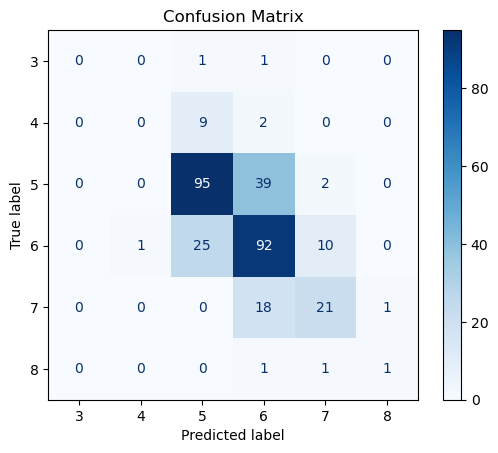

Rank 1:
Params: {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6708272058823529
---
Rank 2:
Params: {'knn__n_neighbors': 13, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6645649509803921
---
Rank 3:
Params: {'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'}
Mean Test Score: 0.6638143382352941
---
Rank 4:
Params: {'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.663795955882353
---
Rank 5:
Params: {'knn__n_neighbors': 24, 'knn__p': 1, 'knn__weights': 'distance'}
Mean Test Score: 0.6630147058823529
---
Rank 6:
Params: {'knn__n_neighbors': 10, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6622273284313726
---
Rank 7:
Params: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'distance'}
Mean Test Score: 0.6622212009803922
---
Rank 8:
Params: {'knn__n_neighbors': 30, 'knn__p': 1, 'knn__weights': 'distance'}
Mean Test Score: 0.6614583333333333
---
Rank 9:
Params: {'knn__n_

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

k_range_limit = 30
param_grid = {
    'knn__n_neighbors': list(range(1, k_range_limit+1)),       # k from 1 to 30
    'knn__weights':     ['uniform', 'distance'],  # uniform vs. distance‐weighted
    'knn__p':           [1, 2],                  # p=1 → Manhattan; p=2 → Euclidean
}

# use the pipeline for testing instead of just a standalone knn model
grid_knn = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv         = 5,         
    scoring    = 'accuracy',   
    n_jobs     = -1,     
    return_train_score=True, # return the training scores for analysis later
    verbose    = 1
)

grid_knn.fit(X_train, y_train)

# Store these vars for later analysis
best_model = grid_knn.best_estimator_
best_params = grid_knn.best_params_
best_cv_accruacy = grid_knn.best_score_
best_index = grid_knn.best_index_
best_cv_results = pd.DataFrame(grid_knn.cv_results_)
optimal_k = best_params['knn__n_neighbors']
optimal_weight = best_params['knn__weights']
optimal_p = best_params['knn__p']


print("Best params:    ", best_params)
print("Best CV acc:    ", best_cv_accruacy)

# evaluate best model on test set
best_y_pred = grid_knn.predict(X_test)
y_pred = grid_knn.predict(X_test)
print("\nAccuracy on test set: ", accuracy_score(y_test, y_pred))

# classification report and confusion report, nicely styled
print("\nTest‐set classification report:\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# print the top 10 best performing models for comparison
all_results = pd.DataFrame(grid_knn.cv_results_)
ten_best_models = all_results.sort_values(by='rank_test_score').head(10)
for _, row in ten_best_models.iterrows():
    print(f"Rank {row['rank_test_score']}:")
    print(f"Params: {row['params']}")
    print(f"Mean Test Score: {row['mean_test_score']}")
    print("---")

#### Observations:
- 'distance' is a clear winner for weights
- for distance metric and k value, there is no clear winner. the K values seem to sit in the range of 10-30.
- Top 4 performing models all have k values between 10-15, so this may be a sweet spot.

In the following graph, we can compare accuracies for different k values and distance metrics, while holding the weight the same (distance)

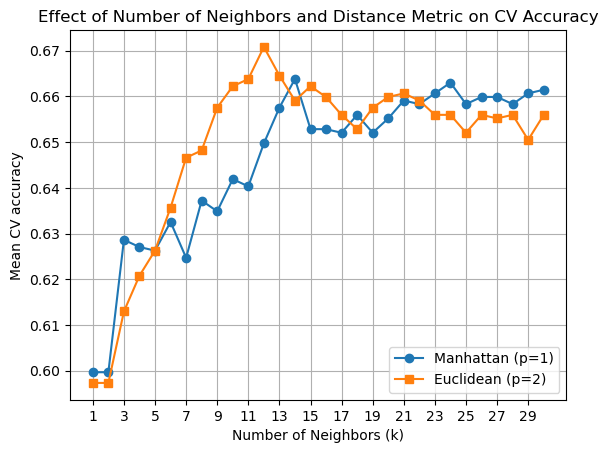

In [11]:
# 1) Filter to distance weighting only and grap k and p vals
results = pd.DataFrame(grid_knn.cv_results_)
filtered_weight = results[results['param_knn__weights'] == 'distance']
filtered_weight['k'] = filtered_weight['param_knn__n_neighbors'].astype(int)
filtered_weight['p'] = filtered_weight['param_knn__p'].astype(int)

# create pivot then plot
pivot_dist = filtered_weight.pivot(index='k', columns='p', values='mean_test_score')
plt.plot(pivot_dist.index, pivot_dist[1], marker='o', label='Manhattan (p=1)')
plt.plot(pivot_dist.index, pivot_dist[2], marker='s', label='Euclidean (p=2)')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV accuracy')
plt.title('Effect of Number of Neighbors and Distance Metric on CV Accuracy')
plt.xticks(range(1, k_range_limit, 2))
plt.legend()
plt.grid(True)
plt.show()

Observations:
- Both Euclidean and Manhatten dist. curves plateau from k = 13 on, sitting between 0.65 and 0.67
- Euclidean dist. is clearly more effective for lower k values, and peaks at 10-13.
- Manhatten dist. gradually climbs and is consistantly higher than euclidean dist. for k > 23

Interpretation:
- the plauteau indicates that the model isn't incredibly sensitive to k onces we reach mid teens, but is slightly sensitive to distance metric in teh later part of that region.
- lower k values risk overfitting, but also decrease bias

In [12]:
# compare training scores with cv scores
print("Best params: ", grid_knn.best_params_)
train_score = best_cv_results.loc[best_index, 'mean_train_score']
valid_score = best_cv_results.loc[best_index, 'mean_test_score']
print(f"Train CV score: {train_score:.3f}")
print(f"Valid CV score: {valid_score:.3f}")

Best params:  {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}
Train CV score: 1.000
Valid CV score: 0.671


Best params:  {'knn__n_neighbors': 12, 'knn__p': 2, 'knn__weights': 'distance'}


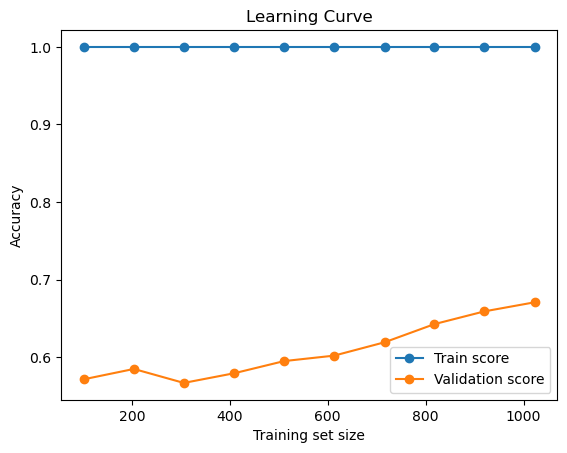

In [13]:
# graph training score compared to validation score for increasing trianing sizes
from sklearn.model_selection import learning_curve

# use the best model from grid search above
best_model
print("Best params: ", best_params)

# returns sizes of training sets, scores on each train set, scores on validation sets
train_sizes, train_scores, validation_scores = learning_curve(
    best_model,
    X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), # % of data to train on (min 10%)
    n_jobs=-1
)

# compute means and stds
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label='Train score')
plt.plot(train_sizes, validation_mean, 'o-', label='Validation score')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

- KNN is a high variance model, so we expect to see the gap between training score and validation score. In this case, the model will always reach 100% accuracy on training folds, which is expected given thet rianing set contains the query points themselves
- To check overfitting, we want to check the model's validation accuracy against the test accuracy. If we see a big drop, that means the model is likely overfit.

Chosen Model Parameters:
Number of neighbors (k): 12
Weights: distance
Distance Metric (p): 2
Accuracy: 0.653125
Macro-F1: 0.3894429253859859

Classification report:



,precision,recall,f1-score,support
3,0.00,0.00,0.00,2.00
4,0.00,0.00,0.00,11.00
5,0.73,0.70,0.71,136.00
6,0.60,0.72,0.65,128.00
7,0.62,0.53,0.57,40.00
8,0.50,0.33,0.40,3.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.41,0.38,0.39,320.00
weighted avg,0.63,0.65,0.64,320.00



Confusion Matrix:


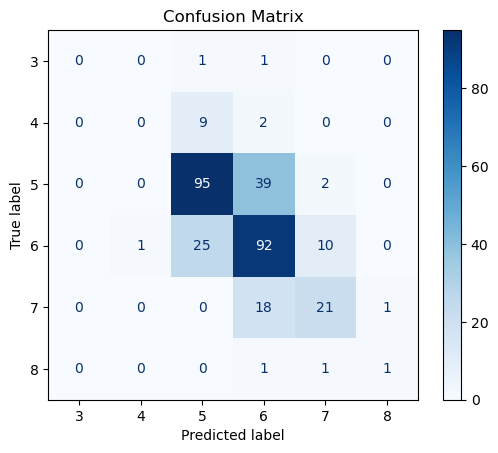

In [15]:
# initialize final chosen model
chosen_model = KNeighborsClassifier(
    n_neighbors=optimal_k,    
    weights=optimal_weight, 
    p=optimal_p,
    n_jobs=-1  
)


chosen_model.fit(X_train_scaled, y_train)
y_pred = chosen_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Chosen Model Parameters:")
print("Number of neighbors (k):", optimal_k)
print("Weights:", optimal_weight )
print("Distance Metric (p):", optimal_p)


print(f"Accuracy: {accuracy}")
print("Macro-F1:", f1_score(y_test, y_pred, average='macro'))

print("\nClassification report:\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.background_gradient(cmap='Blues').format("{:.2f}")
display(styled_report)

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_estimator(chosen_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

There is minial difference between the chosen model's validation accuracy and its accuracy on the held out test data, meaning it's not overfit and we can proceed with this model.